# Inference: So Sánh Phương Pháp MoE + Plugin vs Paper Method (CE + Plugin)

Notebook này thực hiện inference và so sánh phương pháp của bạn (3 Experts + Gating + Plugin) với paper method (CE + Plugin) trên một ảnh tail class.

## Nội dung:
1. Setup và imports
2. Load models và data
3. Chạy Paper Method (CE + Plugin)
4. Chạy Our Method (MoE + Plugin)
5. So sánh từng metric riêng biệt
6. Visualization

## 1. Setup và Imports

In [7]:
# Setup imports
import sys
from pathlib import Path
import json
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output

from src.infer import (
    load_class_to_group,
    load_test_sample_with_image,
    load_image_from_infer_samples,
    load_all_experts,
    load_gating_network,
    load_plugin_params,
    paper_method_pipeline,
    our_method_pipeline,
    plot_ce_only_full_class_distribution,
    plot_full_class_distribution,
    compute_rejection_thresholds_from_test_set,
    BalancedLtRPlugin,
    DATASET, DEVICE, OUTPUT_DIR, EXPERT_DISPLAY_NAMES, NUM_CLASSES, EXPERT_NAMES
)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)

print("✅ Imports successful!")


✅ Imports successful!


## 2. Configuration

In [76]:
# Configuration: Interactive image selection
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

print(f"📁 Dataset: {DATASET}")
print(f"📁 Device: {DEVICE}")

# Initialize variables (will be set by widget)
selected_image_path = None
selected_class_idx = None
selected_group = None
use_cifar100_dataset = False

def scan_infer_samples():
    """Scan infer_samples folder and return available images."""
    infer_samples_dir = Path("./infer_samples")
    images = {
        'Cifar100': {'head': [], 'tail': []},
        'Others': []
    }
    
    # Scan Cifar100 folder
    cifar100_dir = infer_samples_dir / "Cifar100"
    if cifar100_dir.exists():
        for group in ['head', 'tail']:
            group_dir = cifar100_dir / group
            if group_dir.exists():
                for img_file in sorted(group_dir.glob("*.png")):
                    images['Cifar100'][group].append(str(img_file))
    
    # Scan Others folder
    others_dir = infer_samples_dir / "Others"
    if others_dir.exists():
        for img_file in sorted(others_dir.glob("*.png")):
            images['Others'].append(str(img_file))
        for img_file in sorted(others_dir.glob("*.jpg")):
            images['Others'].append(str(img_file))
        for img_file in sorted(others_dir.glob("*.jpeg")):
            images['Others'].append(str(img_file))
    
    return images

def create_image_selector():
    """Create interactive widget to select image."""
    images = scan_infer_samples()
    
    # Create source selector
    source_selector = widgets.RadioButtons(
        options=['infer_samples', 'CIFAR-100 dataset'],
        value='infer_samples',
        description='Image Source:',
        style={'description_width': 'initial'}
    )
    
    # Create category selector for infer_samples
    category_selector = widgets.Dropdown(
        options=['Cifar100 - head', 'Cifar100 - tail', 'Others'],
        value='Cifar100 - tail',
        description='Category:',
        style={'description_width': 'initial'}
    )
    
    # Create image selector
    def get_image_options(category):
        if category == 'Cifar100 - head':
            return images['Cifar100']['head']
        elif category == 'Cifar100 - tail':
            return images['Cifar100']['tail']
        else:
            return images['Others']
    
    image_options = get_image_options(category_selector.value)
    image_selector = widgets.Dropdown(
        options=image_options if image_options else ['No images found'],
        description='Select Image:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='600px')
    )
    
    # CIFAR-100 dataset options
    cifar100_class_selector = widgets.IntText(
        value=70,
        description='Class Index (0-99):',
        style={'description_width': 'initial'},
        disabled=True
    )
    
    cifar100_random_checkbox = widgets.Checkbox(
        value=False,
        description='Random tail class',
        style={'description_width': 'initial'},
        disabled=True
    )
    
    # Output area
    output = widgets.Output()
    
    def update_category(change):
        """Update image options when category changes."""
        new_options = get_image_options(change['new'])
        if new_options:
            image_selector.options = new_options
            image_selector.value = new_options[0] if new_options else None
        else:
            image_selector.options = ['No images found']
    
    def update_source(change):
        """Enable/disable widgets based on source."""
        if change['new'] == 'infer_samples':
            category_selector.disabled = False
            image_selector.disabled = False
            cifar100_class_selector.disabled = True
            cifar100_random_checkbox.disabled = True
        else:
            category_selector.disabled = True
            image_selector.disabled = True
            cifar100_class_selector.disabled = False
            cifar100_random_checkbox.disabled = False
    
    def on_select_button_click(b):
        """Handle select button click."""
        global selected_image_path, selected_class_idx, selected_group, use_cifar100_dataset
        
        with output:
            clear_output(wait=True)
            if source_selector.value == 'infer_samples':
                if image_selector.value and image_selector.value != 'No images found':
                    selected_image_path = Path(image_selector.value)
                    selected_class_idx = None
                    selected_group = None
                    use_cifar100_dataset = False
                    
                    # Try to parse class info from filename
                    filename = selected_image_path.stem
                    parts = filename.split('_')
                    if len(parts) >= 3 and parts[0] in ['head', 'tail']:
                        selected_group = parts[0]
                        try:
                            selected_class_idx = int(parts[1])
                        except:
                            pass
                    
                    print(f"✅ Selected: {selected_image_path.name}")
                    if selected_class_idx is not None:
                        print(f"   Class: {selected_class_idx}, Group: {selected_group}")
                else:
                    print("⚠️  Please select an image")
            else:
                selected_image_path = None
                selected_group = None
                use_cifar100_dataset = True
                if cifar100_random_checkbox.value:
                    selected_class_idx = None
                    print("✅ Selected: Random tail class from CIFAR-100")
                else:
                    selected_class_idx = cifar100_class_selector.value
                    print(f"✅ Selected: Class {selected_class_idx} from CIFAR-100")
    
    category_selector.observe(update_category, names='value')
    source_selector.observe(update_source, names='value')
    
    select_button = widgets.Button(
        description='Select Image',
        button_style='success',
        icon='check'
    )
    select_button.on_click(on_select_button_click)
    
    # Layout
    vbox = widgets.VBox([
        source_selector,
        widgets.HBox([category_selector, image_selector]),
        widgets.HBox([cifar100_class_selector, cifar100_random_checkbox]),
        select_button,
        output
    ])
    
    return vbox

# Display image selector
print("\n" + "="*70)
print("🖼️  IMAGE SELECTOR")
print("="*70)
print("Please select an image using the widget below:")
print()

image_selector_widget = create_image_selector()
display(image_selector_widget)

📁 Dataset: cifar100_lt_if100
📁 Device: cpu

🖼️  IMAGE SELECTOR
Please select an image using the widget below:



## 3. Load Data


📷 Loaded image from: infer_samples/Cifar100/tail/tail_86_telephone.png
   Class: 86 (telephone)
   Image shape: (32, 32, 3)

✅ Tail class - Group: 1


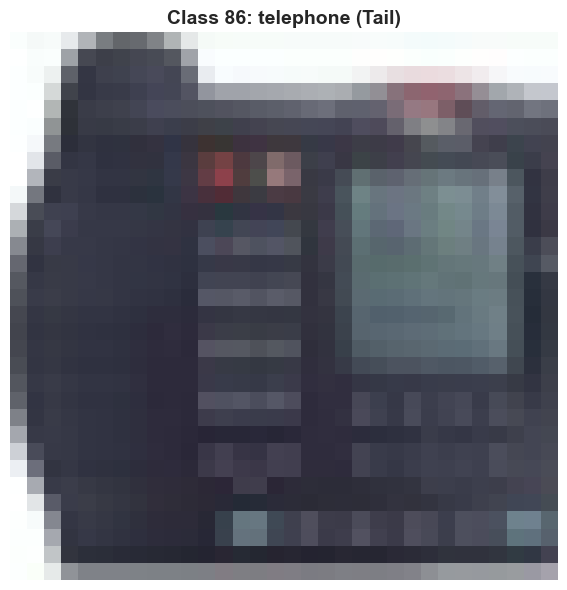

In [136]:
# Load class-to-group mapping
class_to_group = load_class_to_group()

# Load CIFAR-100 class names (for reference)
dataset = torchvision.datasets.CIFAR100(root="./data", train=False, download=False)
class_names = dataset.classes

# Load image based on selection from widget
# Check if image has been selected
if not use_cifar100_dataset and selected_image_path is None and (selected_class_idx is None or selected_group is None):
    raise ValueError(
        "⚠️  Please select an image first!\n"
        "   1. Go to the 'Configuration' cell (section 2)\n"
        "   2. Use the image selector widget to choose an image\n"
        "   3. Click the 'Select Image' button\n"
        "   4. Then run this cell again"
    )

if use_cifar100_dataset:
    # Load from CIFAR-100 dataset
    image_tensor, true_label, image_array, class_name = load_test_sample_with_image(class_idx=selected_class_idx)
else:
    # Load from infer_samples folder
    # Use image_path if available, otherwise use class_idx and group
    if selected_image_path is not None and selected_image_path.exists():
        image_tensor, true_label, image_array, class_name = load_image_from_infer_samples(
            image_path=selected_image_path,
            class_idx=None,
            group=None
        )
    elif selected_class_idx is not None and selected_group is not None:
        image_tensor, true_label, image_array, class_name = load_image_from_infer_samples(
            image_path=None,
            class_idx=selected_class_idx,
            group=selected_group
        )
    else:
        raise ValueError(
            f"Cannot load image: image_path={selected_image_path}, "
            f"class_idx={selected_class_idx}, group={selected_group}\n"
            "Please go back to Configuration cell and select an image."
        )

# Check if it's tail (only if true_label is valid CIFAR-100 class)
if true_label >= 0 and true_label < len(class_to_group):
    is_tail = class_to_group[true_label].item() == 1
    print(f"\n{'✅ Tail class' if is_tail else '⚠️  Not tail class'} - Group: {class_to_group[true_label].item()}")
else:
    print(f"\n⚠️  Note: Class label {true_label} may not be from CIFAR-100 dataset")
    is_tail = None

# TO DO: Plot image
plt.figure(figsize=(6, 6))
plt.imshow(image_array)
plt.title(f"Class {true_label}: {class_name} ({'Tail' if is_tail else 'Head'})", fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()



## 4. Load Models

In [137]:
experts = load_all_experts()
ce_expert = experts[0] 
gating = load_gating_network()

# Load plugin parameters for both methods
ce_plugin_alpha, ce_plugin_mu, ce_plugin_cost = load_plugin_params(method="ce_only", mode="worst")
moe_plugin_alpha, moe_plugin_mu, moe_plugin_cost = load_plugin_params(method="moe", mode="worst")

print("✅ All models and parameters loaded successfully!")


✅ Loaded ce_baseline expert
✅ Loaded logitadjust_baseline expert
✅ Loaded balsoftmax_baseline expert
Loading gating network for 3 experts: ['ce_baseline', 'logitadjust_baseline', 'balsoftmax_baseline']
  Found checkpoint config: routing=top_k, top_k=2
✓ Loaded gating network from: checkpoints/gating_map/cifar100_lt_if100/final_gating.pth
✓ Gating network configured for 3 experts: ['ce_baseline', 'logitadjust_baseline', 'balsoftmax_baseline']
✓ Routing type: top_k, Top-K: 2
✅ Loaded plugin params (ce_only, worst) from results/ltr_plugin/cifar100_lt_if100/ltr_plugin_ce_only_worst.json
   α = [0.77372032 0.01909189], μ = [0.   6.25]
✅ Loaded plugin params (moe, worst) from results/ltr_plugin/cifar100_lt_if100/ltr_plugin_gating_worst.json
   α = [0.65628192 0.01654573], μ = [ 0. 11.]
✅ All models and parameters loaded successfully!


## 5. Paper Method (CE + Plugin)

In [138]:
# Run Paper Method
print("\n" + "="*70)
print("📊 PAPER METHOD (CE + Plugin)")
print("="*70)

paper_result = paper_method_pipeline(
    image_tensor, 
    ce_expert, 
    class_to_group,
    ce_plugin_alpha, 
    ce_plugin_mu, 
    ce_plugin_cost
)

ce_probs = paper_result['probabilities']
ce_top_idx = int(np.argmax(ce_probs))
print("\nCE Posterior (raw softmax):")
print(f"   Top class {ce_top_idx} ({class_names[ce_top_idx]}): {ce_probs[ce_top_idx]:.4f}")
print(f"   True class {true_label} ({class_names[true_label]}): {ce_probs[true_label]:.4f}")

#TO DO: In ra thêm Plugin Reweighted Score 2.8 là class bao nhiêu
predicted_class = paper_result['prediction']
if 'plugin_confidence' in paper_result:
    print(f"Plugin Reweighted Score: {paper_result['plugin_confidence']:.4f} (for class {predicted_class}: {class_names[predicted_class]})")
print(f"Reject: {'YES' if paper_result['reject'] else 'NO'}")
is_correct = paper_result['prediction'] == true_label





📊 PAPER METHOD (CE + Plugin)

CE Posterior (raw softmax):
   Top class 16 (can): 0.9888
   True class 86 (telephone): 0.0005
Plugin Reweighted Score: 2.5559 (for class 16: can)
Reject: YES


## 6. Our Method (MoE + Plugin)

In [139]:
# Run Our Method
print("\n" + "="*70)
print("🚀 OUR METHOD (MoE + Gating + Plugin)")
print("="*70)

print("\n🔧 Using WORST MODE (no beta) from load_plugin_params")
our_result = our_method_pipeline(
    image_tensor, 
    experts, 
    gating, 
    class_to_group,
    moe_plugin_alpha, 
    moe_plugin_mu, 
    moe_plugin_cost,
    plugin_beta=None
)

print(f"\nExpert Predictions: {our_result['expert_predictions']} ({EXPERT_DISPLAY_NAMES})")
print(f"Gating Weights: {our_result['gating_weights']}")
print(f"Prediction (from mixture): Class {our_result['prediction']} ({class_names[our_result['prediction']]})")
print(f"Max Probability: {our_result['confidence']:.4f}")
if 'plugin_confidence' in our_result:
    print(f"Plugin Reweighted Score: {our_result['plugin_confidence']:.4f}")
print(f"Reject: {'YES' if our_result['reject'] else 'NO'}")
is_correct = our_result['prediction'] == true_label



🚀 OUR METHOD (MoE + Gating + Plugin)

🔧 Using WORST MODE (no beta) from load_plugin_params

Expert Predictions: [16, 87, 87] (['CE', 'LogitAdjust', 'BalancedSoftmax'])
Gating Weights: [0.94439334 0.         0.05560667]
Prediction (from mixture): Class 16 (can)
Max Probability: 0.9344
Plugin Reweighted Score: 6.0406
Reject: YES


## 7. Metrics và Visualization

Các metrics và visualization để so sánh hai phương pháp.

### 7.1 Calibration Metrics Comparison

So sánh các calibration metrics trên test set:
- **NLL (Negative Log-Likelihood)**: Đo độ chính xác và calibration
- **Brier Score**: Đo độ chính xác của probabilistic predictions
- **Max-prob ECE**: Expected Calibration Error dựa trên max probability
- **Class-wise ECE**: Expected Calibration Error theo từng class

In [25]:
from pathlib import Path

from src.metrics.plot_combined_metrics_line import (
    compute_nll,
    compute_brier_score,
    compute_max_prob_ece,
    compute_classwise_ece
)

logits_dir = Path(f"./outputs/logits/{DATASET}")
test_logits_available = (logits_dir / "ce_baseline" / "test_logits.pt").exists()

if test_logits_available:
    print("="*70)
    print("COMPREHENSIVE CALIBRATION METRICS COMPARISON")
    print("="*70)
    print("\n📊 Computing calibration metrics on test set...")
    print("   (This may take a few moments...)\n")
    
    import torchvision
    dataset = torchvision.datasets.CIFAR100(root="./data", train=False, download=False)
    splits_dir = Path(f"./data/{DATASET}_splits_fixed")
    with open(splits_dir / "test_indices.json", "r") as f:
        test_indices = json.load(f)
    test_labels = torch.tensor([dataset.targets[i] for i in test_indices], dtype=torch.long, device=DEVICE)
    
    counts_path = splits_dir / "train_class_counts.json"
    with open(counts_path, "r") as f:
        class_counts = json.load(f)
    if isinstance(class_counts, dict):
        class_counts = [class_counts[str(i)] for i in range(NUM_CLASSES)]
    counts = np.array(class_counts, dtype=np.float64)
    total_train = counts.sum()
    train_probs = counts / total_train
    weights = train_probs * NUM_CLASSES
    class_weights = torch.tensor(weights, dtype=torch.float32, device=DEVICE)
    
    posteriors = {}
    
    for expert_name in EXPERT_NAMES:
        logits = torch.load(logits_dir / expert_name / "test_logits.pt", map_location=DEVICE).float()
        posteriors[expert_name] = F.softmax(logits, dim=-1)
    
    # Compute gating mixture posterior
    expert_logits_all = torch.stack([
        torch.load(logits_dir / name / "test_logits.pt", map_location=DEVICE).float()
        for name in EXPERT_NAMES
    ], dim=0).transpose(0, 1)  # [N, 3, 100]
    
    if 'gating_net' not in locals():
        gating_net = load_gating_network()
    
    posteriors["gating_mixture"] = gating_net.get_mixture_posterior_from_logits(expert_logits_all)
    
    methods = ["ce_baseline", "logitadjust_baseline", "balsoftmax_baseline", "gating_mixture"]
    display_names = {
        "ce_baseline": "CE Baseline",
        "logitadjust_baseline": "LogitAdjust",
        "balsoftmax_baseline": "BalSoftmax",
        "gating_mixture": "Gating Mixture",
    }
    
    print("Computing metrics...")
    nll_vals, brier_vals, max_ece_vals, cw_ece_vals = [], [], [], []
    calibration_metrics = {}
    
    for method_name in methods:
        posterior = posteriors[method_name]
        
        nll = compute_nll(posterior, test_labels, class_weights=class_weights)
        brier = compute_brier_score(posterior, test_labels, class_weights=class_weights)
        max_ece = compute_max_prob_ece(posterior, test_labels, n_bins=15, class_weights=class_weights)
        cw_ece = compute_classwise_ece(posterior, test_labels, n_bins=15, class_weights=class_weights)
        
        nll_vals.append(nll)
        brier_vals.append(brier)
        max_ece_vals.append(max_ece)
        cw_ece_vals.append(cw_ece)
        
        calibration_metrics[method_name] = {
            'nll': nll,
            'brier': brier,
            'max_ece': max_ece,
            'cw_ece': cw_ece
        }
        
        print(f"  {display_names[method_name]:<20} NLL={nll:.4f} Brier={brier:.4f} "
              f"Max-ECE={max_ece:.4f} cw-ECE={cw_ece:.4f}")
    
    # Store for plotting
    calibration_metrics['_methods'] = methods
    calibration_metrics['_display_names'] = display_names
    calibration_metrics['_nll_vals'] = nll_vals
    calibration_metrics['_brier_vals'] = brier_vals
    calibration_metrics['_max_ece_vals'] = max_ece_vals
    calibration_metrics['_cw_ece_vals'] = cw_ece_vals
    
    print("\n✅ Calibration metrics computed for all methods!")
else:
    print("⚠️  Test logits not available. Skipping calibration metrics computation.")
    print(f"    (Test logits required: outputs/logits/{DATASET}/*/test_logits.pt)")
    calibration_metrics = None






COMPREHENSIVE CALIBRATION METRICS COMPARISON

📊 Computing calibration metrics on test set...
   (This may take a few moments...)

Computing metrics...
  CE Baseline          NLL=1.8542 Brier=0.5370 Max-ECE=0.1912 cw-ECE=0.0046
  LogitAdjust          NLL=1.5281 Brier=0.4964 Max-ECE=0.0465 cw-ECE=0.0053
  BalSoftmax           NLL=1.6492 Brier=0.5144 Max-ECE=0.0798 cw-ECE=0.0054
  Gating Mixture       NLL=1.5063 Brier=0.5015 Max-ECE=0.1645 cw-ECE=0.0041

✅ Calibration metrics computed for all methods!


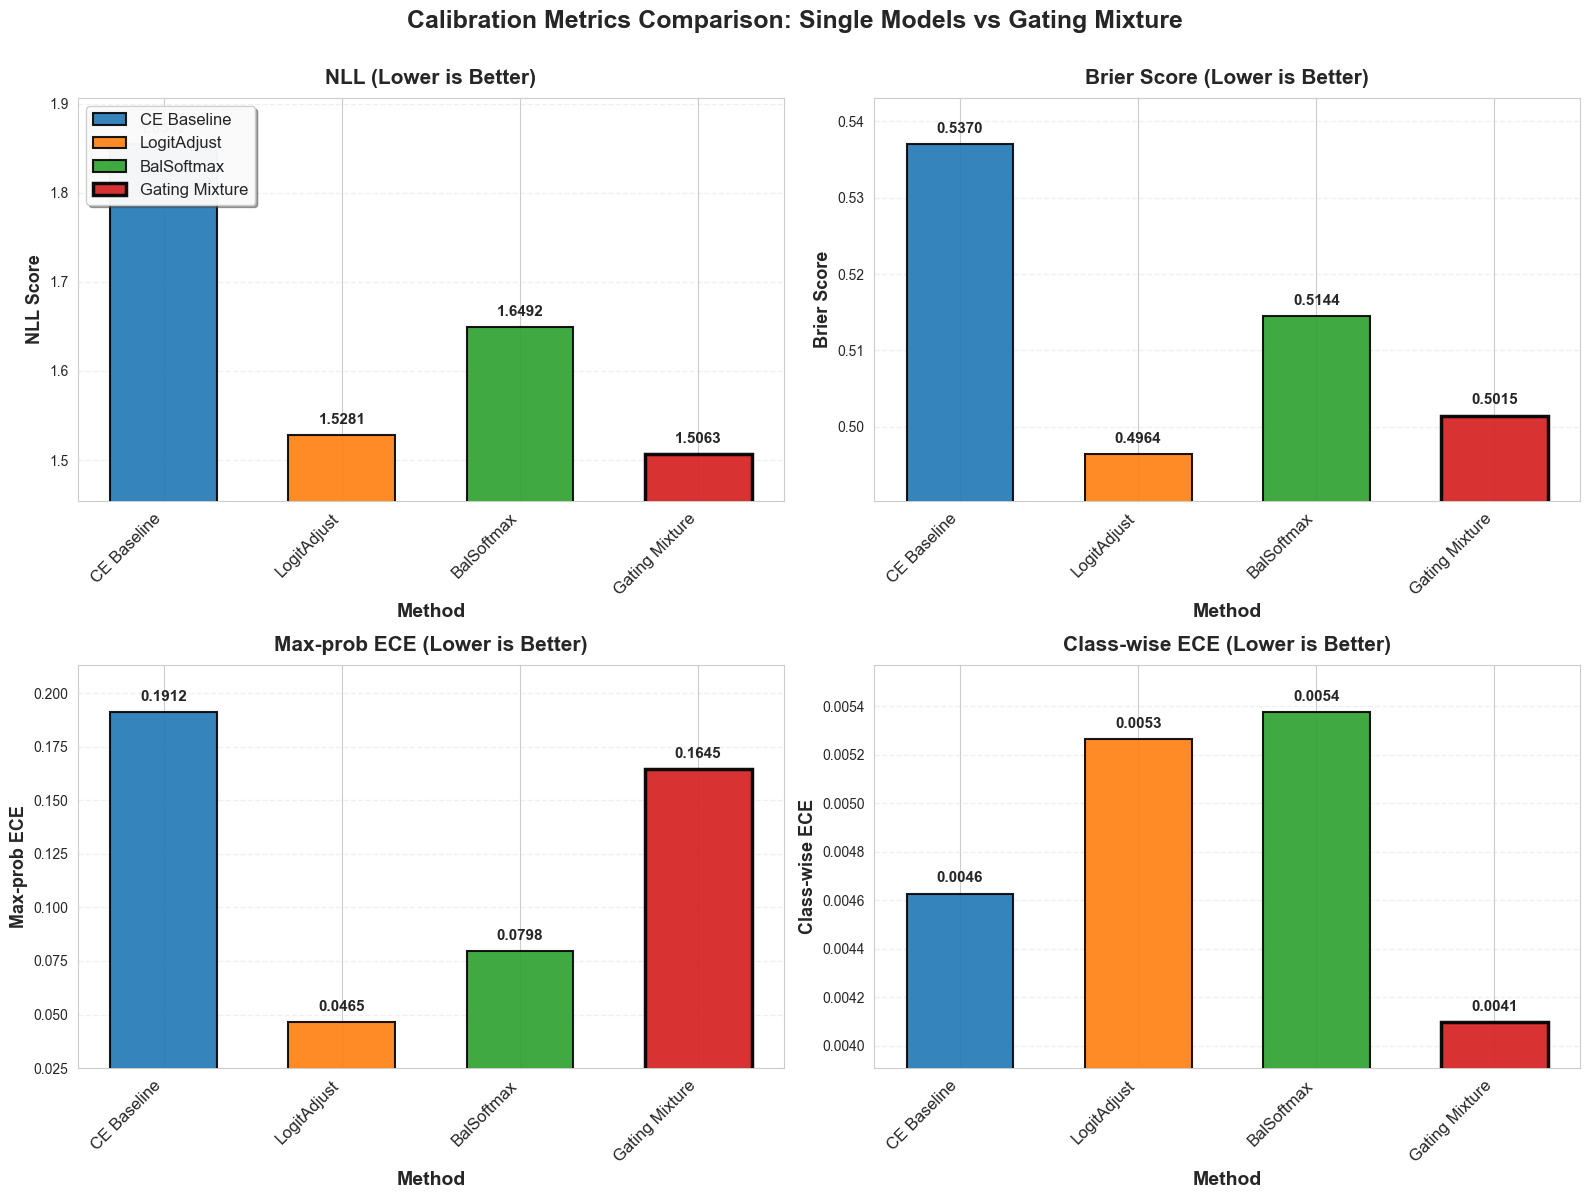


💡 Lower values are better for all metrics.
   This plot shows the raw metric values for all 4 methods.
   Each subplot displays one calibration metric comparison.


In [26]:
if calibration_metrics is not None and '_methods' in calibration_metrics:
    
    # Extract data
    methods = calibration_metrics['_methods']
    display_names = calibration_metrics['_display_names']
    method_labels = [display_names[m] for m in methods]
    
    nll_vals = calibration_metrics['_nll_vals']
    brier_vals = calibration_metrics['_brier_vals']
    max_ece_vals = calibration_metrics['_max_ece_vals']
    cw_ece_vals = calibration_metrics['_cw_ece_vals']
    
    # Define colors for each method (consistent with other plots)
    method_colors = {
        "CE Baseline": "#1f77b4",      # Blue
        "LogitAdjust": "#ff7f0e",       # Orange
        "BalSoftmax": "#2ca02c",        # Green
        "Gating Mixture": "#d62728",    # Red
    }
    
    # Create 2x2 subplot figure
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Calibration Metrics Comparison: Single Models vs Gating Mixture',
                 fontsize=18, fontweight='bold', y=0.995)
    
    metrics_info = [
        ("NLL", nll_vals, "NLL Score"),
        ("Brier Score", brier_vals, "Brier Score"),
        ("Max-prob ECE", max_ece_vals, "Max-prob ECE"),
        ("Class-wise ECE", cw_ece_vals, "Class-wise ECE"),
    ]
    
    for idx, (metric_name, raw_vals, ylabel) in enumerate(metrics_info):
        row = idx // 2
        col = idx % 2
        ax = axes[row, col]
        
        # Use raw values (no normalization)
        vals = raw_vals
        
        # Set up bar positions
        x = np.arange(len(method_labels))
        width = 0.6
        
        bars = []
        for i, method in enumerate(method_labels):
            color = method_colors.get(method, 'gray')
            edgewidth = 2.5 if method == "Gating Mixture" else 1.5
            alpha = 0.95 if method == "Gating Mixture" else 0.9
            
            bar = ax.bar(i, vals[i], width, 
                        label=method if idx == 0 else "",  # Only label in first subplot
                        color=color, alpha=alpha,
                        edgecolor='black', linewidth=edgewidth, zorder=5)
            bars.append(bar)
        
        # Calculate y-axis limits based on actual values
        max_val = max(vals)
        min_val = min(vals)
        y_range = max_val - min_val
        y_margin = y_range * 0.15 if y_range > 0 else max_val * 0.1
        y_min = max(0, min_val - y_margin)
        y_max = max_val + y_margin
        
        # Formatting
        ax.set_xlabel('Method', fontsize=14, fontweight='bold')
        ax.set_ylabel(ylabel, fontsize=13, fontweight='bold')
        ax.set_title(f'{metric_name} (Lower is Better)', fontsize=15, fontweight='bold', pad=10)
        ax.set_xticks(x)
        ax.set_xticklabels(method_labels, rotation=45, ha='right', fontsize=12)
        ax.set_ylim([y_min, y_max])
        ax.grid(True, alpha=0.3, linestyle='--', linewidth=1.0, axis='y', zorder=0)
        
        # Add value labels on bars
        for i, bar in enumerate(bars):
            height = vals[i]
            label_y = height + (y_max - y_min) * 0.02
            ax.text(i, label_y, f'{height:.4f}', 
                   ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    axes[0, 0].legend(loc='upper left', fontsize=12, framealpha=0.95,
                     fancybox=True, shadow=True, ncol=1)
    
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()
    
    print("\n💡 Lower values are better for all metrics.")
    print("   This plot shows the raw metric values for all 4 methods.")
    print("   Each subplot displays one calibration metric comparison.")
else:
    print("⚠️  Calibration metrics not available. Please run the previous cell first.")


# TO DO: Plot lại các bảng

### 7.2 Full-Class Posterior Distribution (All Methods)

Biểu đồ phân bố xác suất trên 100 classes cho tất cả các methods: CE, LogitAdjust, BalancedSoftmax, và Gating Mixture.

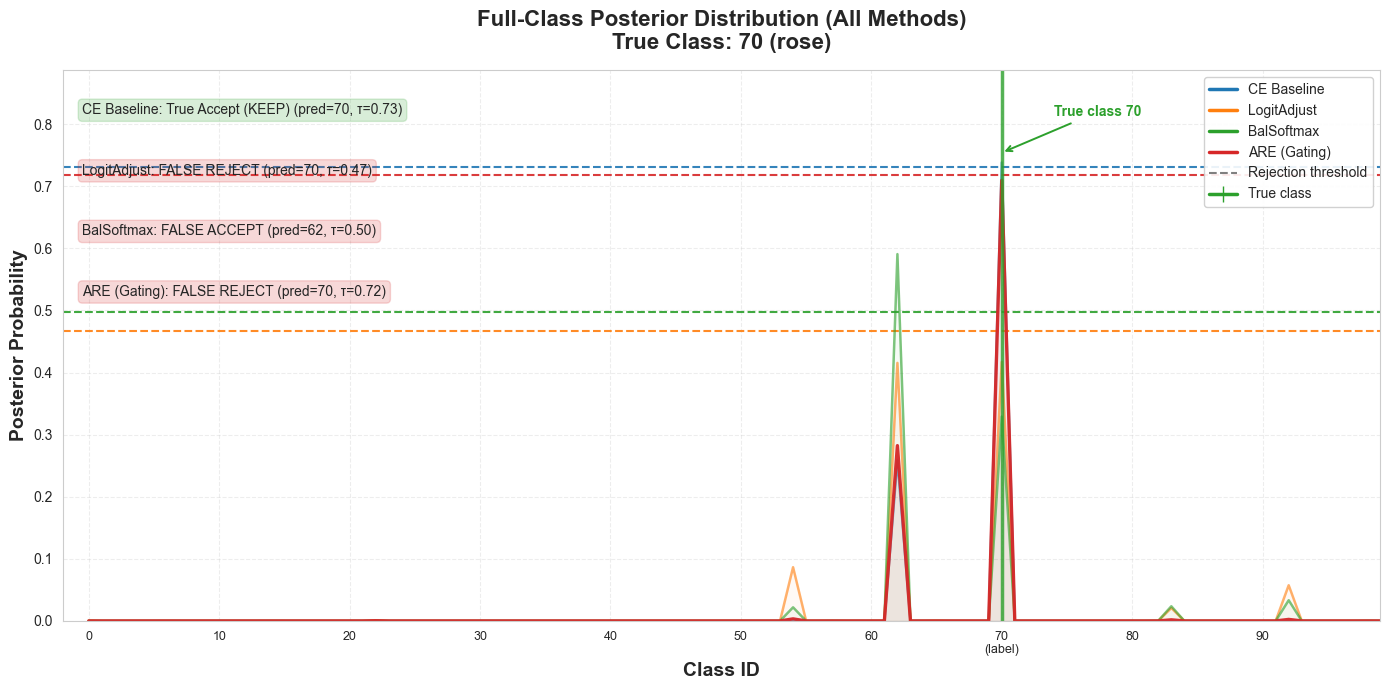

💡 Biểu đồ này hiển thị đồng thời CE, LogitAdjust, BalSoftmax và Gating (ARE)
   để so sánh phân bố xác suất và (nếu có) quyết định KEEP/REJECT của từng phương pháp.


In [27]:
# Plot full-class posterior distribution for all methods (CE, LA, BS, Gating)

# Compute thresholds if not available yet (for max-prob Chow-style decision lines)
if 'thresholds' not in locals() or thresholds is None:
    print("Computing rejection thresholds from test set...")
    print("   (Thresholds require full test set - sẽ bỏ qua nếu không có dữ liệu)")
    thresholds = compute_rejection_thresholds_from_test_set(target_rejection=0.4)

fig_all = plot_full_class_distribution(
    true_label=true_label,
    paper_result=paper_result,
    our_result=our_result,
    class_names=class_names,
    thresholds=thresholds,
    title=f"Full-Class Posterior Distribution (All Methods)\nTrue Class: {true_label} ({class_names[true_label]})"
)
plt.show()

print("💡 Biểu đồ này hiển thị đồng thời CE, LogitAdjust, BalSoftmax và Gating (ARE)")
print("   để so sánh phân bố xác suất và (nếu có) quyết định KEEP/REJECT của từng phương pháp.")


### 7.3 Paper Method (CE + Plugin) – Full-Class Posterior

Biểu đồ phân bố xác suất CE-only của Paper Method trên 100 classes.

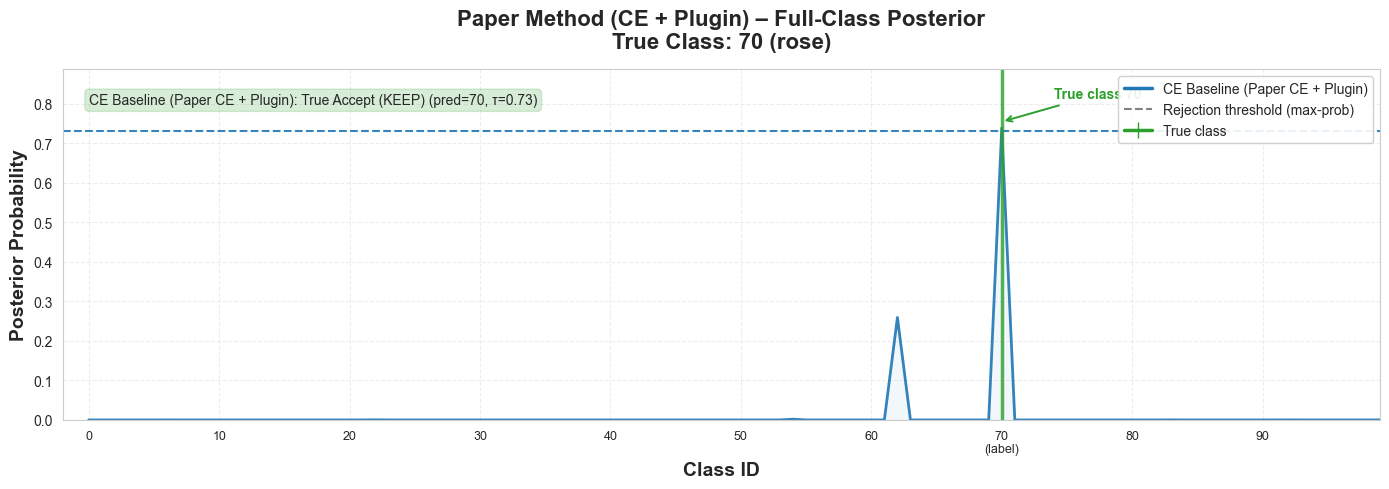

💡 Biểu đồ này cho thấy rõ cách CE (Paper Method) phân bố xác suất trên 100 classes,
   và (nếu có) đường ngưỡng max-prob τ mà theo đó CE sẽ KEEP/REJECT sample này.


In [28]:
# Plot CE-only full-class posterior for Paper Method (CE + Plugin)

# Ensure `thresholds` exists (if previous cell was skipped)
if 'thresholds' not in locals():
    thresholds = None

# Lấy threshold cho CE nếu đã tính được từ test set
ce_threshold = None
if thresholds is not None and isinstance(thresholds, dict):
    ce_threshold = thresholds.get('ce_baseline')

fig_ce = plot_ce_only_full_class_distribution(
    true_label=true_label,
    paper_result=paper_result,
    class_names=class_names,
    threshold=ce_threshold,
    title=f"Paper Method (CE + Plugin) – Full-Class Posterior\nTrue Class: {true_label} ({class_names[true_label]})",
)
plt.show()

print("💡 Biểu đồ này cho thấy rõ cách CE (Paper Method) phân bố xác suất trên 100 classes,")
print("   và (nếu có) đường ngưỡng max-prob τ mà theo đó CE sẽ KEEP/REJECT sample này.")



### 7.5 Plugin Reject Rule Terms

So sánh trực tiếp hai vế của công thức reject: `max_reweighted` (vế trái) và `threshold = Σ(1/α̂ - μ)·η(x) - cost` (vế phải).


In [29]:
def compute_plugin_terms(posterior, plugin_params, class_to_group_tensor):
    alpha = np.array(plugin_params['alpha'])
    mu = np.array(plugin_params['mu'])
    cost = float(plugin_params['cost'])
    plugin = BalancedLtRPlugin(class_to_group_tensor, alpha, mu, cost)
    posterior_tensor = torch.tensor(posterior, dtype=torch.float32, device=class_to_group_tensor.device).unsqueeze(0)
    eps = 1e-12
    alpha_hat = plugin._alpha_hat_class().clamp(min=eps)
    mu_tensor = plugin._mu_class()
    inv_alpha_hat = 1.0 / alpha_hat
    lhs = (posterior_tensor * inv_alpha_hat.unsqueeze(0)).max(dim=-1)[0].item()
    rhs = ((inv_alpha_hat - mu_tensor).unsqueeze(0) * posterior_tensor).sum(dim=-1).item() - plugin.cost
    return lhs, rhs

paper_lhs, paper_rhs = compute_plugin_terms(
    paper_result['probabilities'],
    paper_result['plugin_params'],
    class_to_group,
)
our_lhs, our_rhs = compute_plugin_terms(
    our_result['mixture_posterior'],
    our_result['plugin_params'],
    class_to_group,
)

print("📊 Plugin reject rule terms (max_reweighted vs threshold):")
print(f"   Paper Method: max_reweighted = {paper_lhs:.4f}, threshold = {paper_rhs:.4f}")
print(f"   Our Method:   max_reweighted = {our_lhs:.4f}, threshold = {our_rhs:.4f}")
print("\n   💡 Rule: Reject nếu max_reweighted < threshold (per-sample).")

# Print plugin parameters (excluding cost), posterior max, and variance
print("\n" + "="*70)
print("📈 ADDITIONAL STATISTICS")
print("="*70)

# Paper Method statistics
paper_posterior = np.array(paper_result['probabilities'])
paper_posterior_max = paper_posterior.max()
paper_posterior_var = paper_posterior.var()

print("\n📊 Paper Method (CE + Plugin):")
print(f"   Plugin Parameters:")
print(f"     α (alpha): {paper_result['plugin_params']['alpha']}")
print(f"     μ (mu): {paper_result['plugin_params']['mu']}")
print(f"   Posterior Statistics:")
print(f"     Max probability: {paper_posterior_max:.6f}")
print(f"     Variance: {paper_posterior_var:.6f}")

# Our Method statistics
our_posterior = np.array(our_result['mixture_posterior'])
our_posterior_max = our_posterior.max()
our_posterior_var = our_posterior.var()

print("\n📊 Our Method (MoE + Gating + Plugin):")
print(f"   Plugin Parameters:")
if 'beta' in our_result['plugin_params'] and our_result['plugin_params']['beta'] is not None:
    print(f"     α (alpha): {our_result['plugin_params']['alpha']}")
    print(f"     μ (mu): {our_result['plugin_params']['mu']}")
    print(f"     β (beta): {our_result['plugin_params']['beta']}")
    print(f"     Mode: {our_result['plugin_params'].get('mode', 'unknown')}")
else:
    print(f"     α (alpha): {our_result['plugin_params']['alpha']}")
    print(f"     μ (mu): {our_result['plugin_params']['mu']}")
    print(f"     Mode: {our_result['plugin_params'].get('mode', 'balanced')}")
print(f"   Posterior Statistics:")
print(f"     Max probability: {our_posterior_max:.6f}")
print(f"     Variance: {our_posterior_var:.6f}")

print("="*70)

📊 Plugin reject rule terms (max_reweighted vs threshold):
   Paper Method: max_reweighted = 77.3475, threshold = 73.4179
   Our Method:   max_reweighted = 85.7748, threshold = 78.8601

   💡 Rule: Reject nếu max_reweighted < threshold (per-sample).

📈 ADDITIONAL STATISTICS

📊 Paper Method (CE + Plugin):
   Plugin Parameters:
     α (alpha): [0.773720321731544, 0.01909189017661485]
     μ (mu): [0.0, 6.25]
   Posterior Statistics:
     Max probability: 0.738355
     Variance: 0.006023

📊 Our Method (MoE + Gating + Plugin):
   Plugin Parameters:
     α (alpha): [0.6562819202314765, 0.016545729754491756]
     μ (mu): [0.0, 11.0]
     Mode: balanced
   Posterior Statistics:
     Max probability: 0.709603
     Variance: 0.005733


### 7.6 Rejection Decision

In [30]:
# Rejection Decision Comparison với 4 trường hợp

def classify_rejection_decision(prediction, true_label, reject):
    """
    Phân loại rejection decision thành 4 trường hợp:
    - True Accept (TA): Accept và đúng → Tốt nhất!
    - False Accept (FA): Accept nhưng sai → Nguy hiểm!
    - False Reject (FR): Reject nhưng đúng → Lãng phí (nên accept)
    - True Reject (TR): Reject và sai → Đúng nên reject
    """
    is_correct = (prediction == true_label)
    
    if not reject:  # ACCEPT
        if is_correct:
            return "True Accept (TA)", "✅"
        else:
            return "False Accept (FA)", "❌"
    else:  # REJECT
        if is_correct:
            return "False Reject (FR)", "⚠️"
        else:
            return "True Reject (TR)", "✅"

# Paper Method
paper_pred = paper_result['prediction']
paper_reject = paper_result['reject']
paper_decision, paper_icon = classify_rejection_decision(paper_pred, true_label, paper_reject)

# Our Method
our_pred = our_result['prediction']
our_reject = our_result['reject']
our_decision, our_icon = classify_rejection_decision(our_pred, true_label, our_reject)

print("📊 Rejection Decision Analysis:")
print("="*70)
print(f"   True Label: {true_label} ({class_names[true_label]})")
print(f"📄 Paper Method (CE + Plugin):")
print(f"   Reject: {'YES' if paper_reject else 'NO'}")
print(f"   Decision: {paper_decision} {paper_icon}")

print(f"🚀 Our Method (MoE + Gating + Plugin):")
print(f"   Reject: {'YES' if our_reject else 'NO'}")
print(f"   Decision: {our_decision} {our_icon}")


📊 Rejection Decision Analysis:
   True Label: 70 (rose)
📄 Paper Method (CE + Plugin):
   Reject: NO
   Decision: True Accept (TA) ✅
🚀 Our Method (MoE + Gating + Plugin):
   Reject: NO
   Decision: True Accept (TA) ✅


### 7.8 Expert Contributions (Our Method Only)

📊 Expert Contributions:
   CE:
      Prediction: 70 (rose) ✅
      Gating Weight: 0.9297
      Max Probability: 0.7384
   LogitAdjust:
      Prediction: 70 (rose) ✅
      Gating Weight: 0.0000
      Max Probability: 0.4171
   BalancedSoftmax:
      Prediction: 62 (poppy) ❌
      Gating Weight: 0.0703
      Max Probability: 0.5908


/var/folders/bw/q82tr8kx6ll_854mt69fk2_r0000gn/T/ipykernel_45377/385168248.py:40: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/bw/q82tr8kx6ll_854mt69fk2_r0000gn/T/ipykernel_45377/385168248.py:40: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/envs/DEGRE/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/DEGRE/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


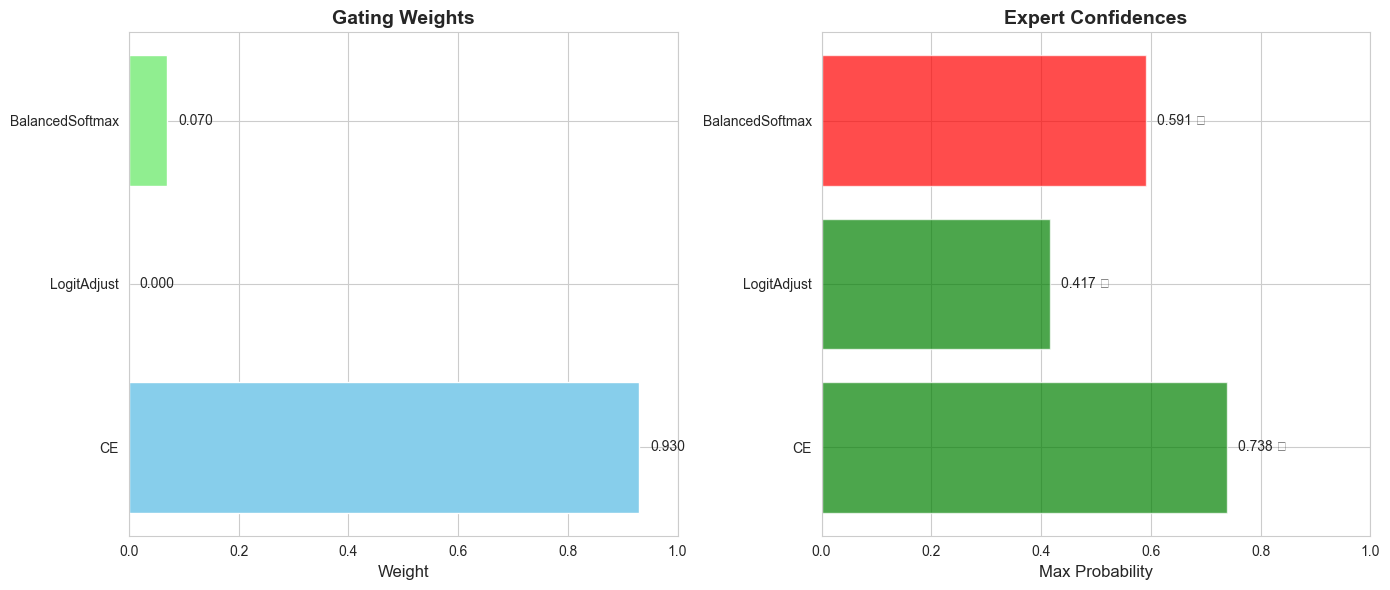

In [31]:
# Expert Contributions
expert_names = EXPERT_DISPLAY_NAMES
expert_preds = our_result['expert_predictions']
gating_weights = our_result['gating_weights']
expert_probs = our_result['expert_probs']

print("📊 Expert Contributions:")
for i, (name, pred, weight, probs) in enumerate(zip(expert_names, expert_preds, gating_weights, expert_probs)):
    correct = '✅' if pred == true_label else '❌'
    max_prob = np.max(probs)
    print(f"   {name}:")
    print(f"      Prediction: {pred} ({class_names[pred]}) {correct}")
    print(f"      Gating Weight: {weight:.4f}")
    print(f"      Max Probability: {max_prob:.4f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gating weights
ax1 = axes[0]
ax1.barh(expert_names, gating_weights, color=['skyblue', 'lightcoral', 'lightgreen'])
ax1.set_xlabel('Weight', fontsize=12)
ax1.set_title('Gating Weights', fontsize=14, fontweight='bold')
ax1.set_xlim([0, 1])
for i, (name, weight) in enumerate(zip(expert_names, gating_weights)):
    ax1.text(weight + 0.02, i, f'{weight:.3f}', va='center', fontsize=10)

# Expert confidences
ax2 = axes[1]
expert_confidences = [np.max(probs) for probs in expert_probs]
colors = ['green' if pred == true_label else 'red' for pred in expert_preds]
ax2.barh(expert_names, expert_confidences, color=colors, alpha=0.7)
ax2.set_xlabel('Max Probability', fontsize=12)
ax2.set_title('Expert Confidences', fontsize=14, fontweight='bold')
ax2.set_xlim([0, 1])
for i, (name, conf, pred) in enumerate(zip(expert_names, expert_confidences, expert_preds)):
    status = '✅' if pred == true_label else '❌'
    ax2.text(conf + 0.02, i, f'{conf:.3f} {status}', va='center', fontsize=10)

plt.tight_layout()
plt.show()